In [3]:
from tensorflow.keras.utils import image_dataset_from_directory


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("smaranjitghose/corn-or-maize-leaf-disease-dataset")

print("Path to dataset files:", path)

C:\Users\gharr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\gharr\.cache\kagglehub\datasets\smaranjitghose\corn-or-maize-leaf-disease-dataset\versions\1


In [5]:
data = r'C:\Users\gharr\.cache\kagglehub\datasets\smaranjitghose\corn-or-maize-leaf-disease-dataset\versions\1\data'
import tensorflow as tf
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    data,
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.3,
    subset="training",
    seed=42
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    data,
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.3,
    subset="validation",
    seed=42
)

class_names = train_ds_raw.class_names

print("Classes:", class_names)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds_raw.map(lambda x, y: (x/255.0, y)).cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds_raw.map(lambda x, y: (x/255.0, y)).cache().prefetch(AUTOTUNE)



Found 4188 files belonging to 4 classes.
Using 2932 files for training.
Found 4188 files belonging to 4 classes.
Using 1256 files for validation.
Classes: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


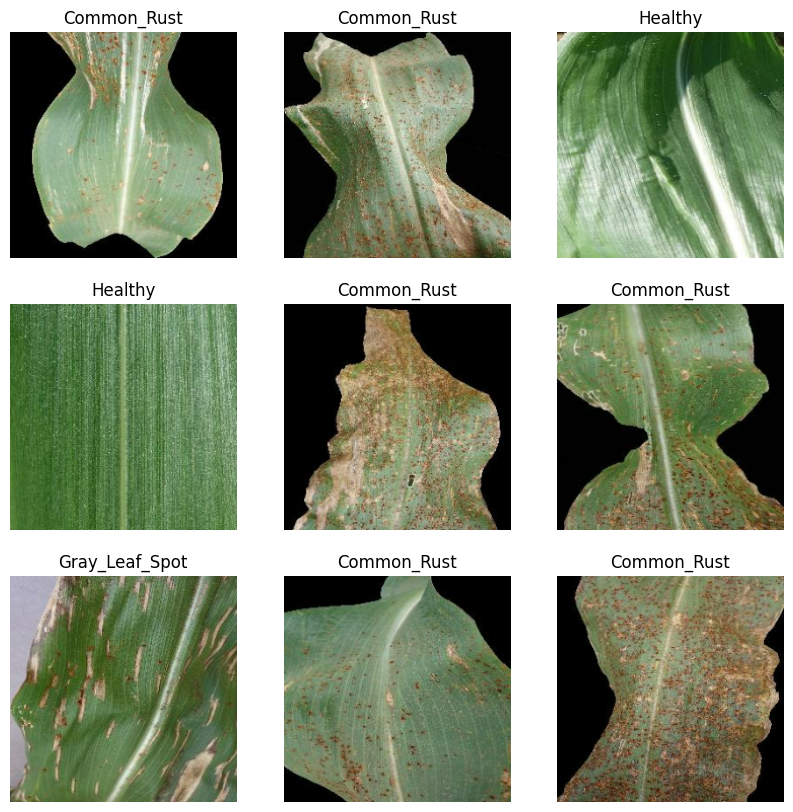

In [6]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
    break


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3
)


In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False  # freeze base layers for faster training


In [9]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=6)


Epoch 1/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 71s 696ms/step - accuracy: 0.8820 - loss: 0.3121 - val_accuracy: 0.9021 - val_loss: 0.2418
Epoch 2/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 60s 658ms/step - accuracy: 0.9338 - loss: 0.1626 - val_accuracy: 0.8734 - val_loss: 0.3252
Epoch 3/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 60s 653ms/step - accuracy: 0.9560 - loss: 0.1169 - val_accuracy: 0.9076 - val_loss: 0.2372
Epoch 4/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 639ms/step - accuracy: 0.9683 - loss: 0.0866 - val_accuracy: 0.9164 - val_loss: 0.2242
Epoch 5/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 70s 765ms/step - accuracy: 0.9737 - loss: 0.0687 - val_accuracy: 0.9164 - val_loss: 0.2258
Epoch 6/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 68s 740ms/step - accuracy: 0.9795 - loss: 0.0545 - val_accuracy: 0.9100 - val_loss: 0.2756


In [10]:
print(class_names)

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions
Y_pred = model.predict(val_ds)
y_pred = np.argmax(Y_pred, axis=1)

# Extract true labels from the dataset
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# If one-hot encoded labels:
if y_true.ndim > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))
# Optional: confusion matrix
print(confusion_matrix(y_true, y_pred))


40/40 ━━━━━━━━━━━━━━━━━━━━ 24s 529ms/step
                precision    recall  f1-score   support

        Blight       0.80      0.93      0.86       339
   Common_Rust       0.97      0.96      0.96       383
Gray_Leaf_Spot       0.84      0.61      0.70       183
       Healthy       1.00      0.99      1.00       351

      accuracy                           0.91      1256
     macro avg       0.90      0.87      0.88      1256
  weighted avg       0.91      0.91      0.91      1256

[[315   7  17   0]
 [ 11 369   3   0]
 [ 67   5 111   0]
 [  1   1   1 348]]


In [12]:
#want to get just accuracy from model
loss, accuracy = model.evaluate(val_ds)
print("Validation Accuracy:", accuracy)
print('Loss:', loss)

40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 459ms/step - accuracy: 0.9100 - loss: 0.2756
Validation Accuracy: 0.9100318551063538
Loss: 0.27556440234184265


In [24]:
#test with image.png
import numpy as np
from tensorflow.keras.preprocessing import image
img_path = 'image.png'  # replace with your image path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Create batch axis
img_array = img_array / 255.0  # Rescale if necessary
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)
print("Predicted class:", class_names[predicted_class[0]])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Predicted class: Blight
